# Visualized AIMD EXAFS from FEFF
Data courtesy of Micah Prange and Eugene Ilton

In [1]:
import utils
from importlib import reload

utils = reload(utils)
from utils import *

## Get data and visualize

In [2]:
datafiles = os.listdir('Data/')
Data = np.array([read_file(f'Data/{filename}') for filename in datafiles])
print(Data.shape)

(839, 414, 4)


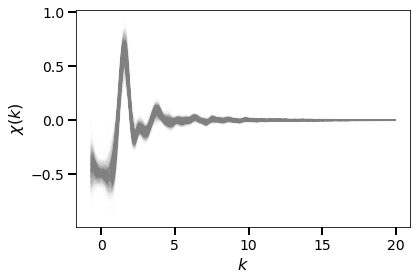

In [3]:
fig, ax = plt.subplots(figsize=(6, 4))
for run in Data:
    plt.plot(run[:, 0], run[:, 1], '-', c='gray', alpha=0.01)
ax.tick_params(direction='out', width=2, length=8, which='major', labelsize=14)
ax.set_xlabel('$k$', fontsize=16)
ax.set_ylabel('$\chi(k)$', fontsize=16)
plt.show()

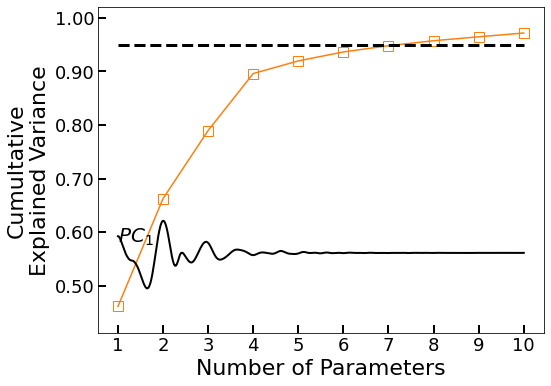

In [4]:
make_scree_plot(Data[:, :, 1], n=10)